<a href="https://colab.research.google.com/github/PeterJackNaylor/NN-4-change-detection/blob/master/Unsupervised_CD_with_INR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Unsupervised Urban Change Detection with Implicit Neural Representations

In [ ]:
!pip install plyfile optuna torchlars
!git clone https://github.com/PeterJackNaylor/NN-4-change-detection.git

In [2]:
import sys
import os
import zipfile
import numpy as np
import pandas as pd
from glob import glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize, Compose, ToTensor, Normalize

import matplotlib.pyplot as plt

from pathlib import Path
from plyfile import PlyData

sys.path.append("./NN-4-change-detection/python/src")
from data_XYZ import XYZ
from parser import AttrDict
from architectures import ReturnModel, gen_b
from function_estimation import estimate_density, predict_loop


In [ ]:
# With this we can import the files from google drive
from google.colab import drive
drive.mount('/content/drive')

## Load Data

In [4]:
tmp_dir = Path("/tmp/")
# I uploaded a zip file containing all paired ply files to my google drive in a folder named colab_data
path_zip = Path("/content/drive/My Drive/colab_data/Urban3dcd_v2_testset.zip")


with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(tmp_dir)

!ls /tmp/Urban3dcd_v2_testset

Lidar05_LyonS_0.ply   Lidar05_LyonS4_0.ply     MultiSensor_LyonS3_0.ply
Lidar05_LyonS_1.ply   Lidar05_LyonS4_1.ply     MultiSensor_LyonS3_1.ply
Lidar05_LyonS3_0.ply  MultiSensor_LyonS_0.ply  MultiSensor_LyonS4_0.ply
Lidar05_LyonS3_1.ply  MultiSensor_LyonS_1.ply  MultiSensor_LyonS4_1.ply


In [ ]:
data_names = glob(str(tmp_dir / 'Urban3dcd_v2_testset' / '*_0.ply'))
def as_ref_1(fpath):
  # files go by pair
  return str(fpath).replace("_0.ply", "_1.ply")

def ply_to_npy(f):
    with open(f, "rb") as f:
        plydata = PlyData.read(f)
    data = plydata["params"]
    x = data.data["x"]
    y = data.data["y"]
    z = data.data["z"]
    label = data.data["label_ch"]

    table = np.vstack([x, y, z, label]).T
    return table


file0 = data_names[-1]
file1 = as_ref_1(file0)

pc0 = ply_to_npy(file0) # [XYZL x 4]
pc1 = ply_to_npy(file1) # [XYZL x 4]

print(pc0.shape)
print(pc1.shape)

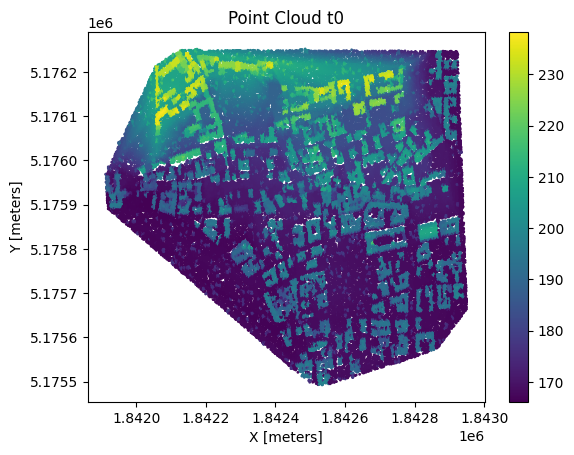

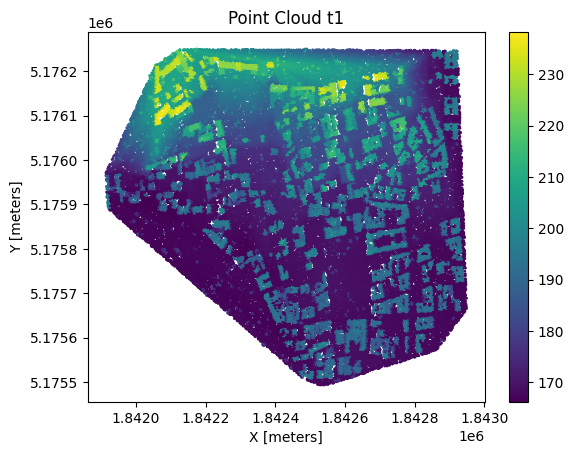

In [6]:
# Data visualization in x,y plane
# z encoded as color
ds = 4 # hard downsampling, just to make everything a bit faster

plt.scatter(pc0[::ds,0], pc0[::ds,1], c=pc0[::ds,2], s=1)
plt.title('Point Cloud t0')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()

plt.scatter(pc1[::ds,0], pc1[::ds,1], c=pc1[::ds,2], s=1)
plt.title('Point Cloud t1')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()

In [ ]:
class XYZ_ply(XYZ):
  def read_table(self, path, time):
    pc = ply_to_npy(path)
    table = pd.DataFrame(pc)
    table.columns = ["X", "Y", "Z", "label"]
    table["T"] = time
    return table[["X", "Y", "Z", "T"]]

### Training configuration

dataset_id = -1

opt = AttrDict() # Usually comes from the parser, general experimental settings
opt.path_ply0 = data_names[dataset_id]
opt.path_ply1 = as_ref_1(opt.path_ply0)
opt.model = "RFF" # or siren. "RFF"
opt.name = "ColabExample"
opt.normalize = "one_minus"
opt.time = True
opt.seed = 42
opt.train_fraction = 0.8
opt.verbose = False

model_hp = AttrDict() # Specific model settings, mostly variables for hyper-parameter tuning
model_hp.bs = 2 ** 12 # batch size
model_hp.method = "M+TD+TVN"# +TD+TVN" # Method to apply, with '+' 'M+TD+TVN'
model_hp.epochs = 100 # Number of epochs

model_hp.scale = 16  # scale used for scaling or RFF mapping or SIREN w0 parameter
model_hp.lr = 5e-05    # learning rate

model_hp.fourier = opt.model == "RFF"
model_hp.siren = opt.model == "siren"
if opt.model == "siren":
  model_hp.architecture = "siren"
  model_hp.siren_hidden_num = 6   # number of layer for SIREN
  model_hp.siren_hidden_dim = 256 # number of units per layer
  model_hp.siren_skip = True      # If to use skip layer on paired id layers.
else:
  model_hp.mapping_size = 512       # number of hidden units for the RFF (size of $\gamma(v)$ )
  model_hp.architecture = "skip-ten-only"# model archecture
  model_hp.activation = "relu"    # activation function

model_hp.TD = "TD" in model_hp.method
model_hp.tvn = "TVN" in model_hp.method
if model_hp.TD:
    model_hp.lambda_td = 0.05  # Scaler for penalising the time difference
if model_hp.tvn:
    model_hp.lambda_tvn = 3e-05       # Scaler for penalising the spatial gradient
model_hp.verbose = True



## Data setup
xyz_train = XYZ_ply(
  opt.path_ply0,
  opt.path_ply1,
  train_fold=True,
  train_fraction=opt.train_fraction,
  seed=opt.seed,
  pred_type="table_predictions",
  nv=None,
  normalize=opt.normalize,
  time=opt.time,
  method=model_hp.method,
)
nv = xyz_train.nv

xyz_test = XYZ_ply(
  opt.path_ply0,
  opt.path_ply1,
  train_fold=False,
  train_fraction=opt.train_fraction,
  seed=opt.seed,
  pred_type="table_predictions",
  nv=nv,
  normalize=opt.normalize,
  time=opt.time,
  method="M", #unimportant in test
)

## Model setup

model_hp.nv = nv
if model_hp.fourier:
  model_hp.B = gen_b(
      model_hp.mapping_size,
      model_hp.scale,
      xyz_train.input_size,
  )

model = ReturnModel(
    xyz_train.input_size,
    arch=model_hp.architecture,
    args=model_hp,
)

model = model.cuda()

model, best_score = estimate_density(
    xyz_train,
    xyz_test,
    model,
    model_hp,
    opt.name,
    trial=None,
    return_model=True,
)

In [ ]:
xyz_grid = XYZ_ply(
  opt.path_ply1,
  None,
  train_fold=True,
  train_fraction=1.0,
  pred_type="table_predictions",
  seed=42,
  nv=model_hp.nv,
  normalize=opt.normalize,
  time=opt.time,
  method=model_hp.method,
)
xyz_grid.samples[:,-1] = 0
predictions0 = predict_loop(xyz_grid, model_hp.bs, model.eval())
xyz_grid.samples[:,-1] = 1
predictions1 = predict_loop(xyz_grid, model_hp.bs, model.eval())

xy = np.array(xyz_grid.samples.cpu())
x = xy[:, 0] * nv[0][1] + nv[0][0]
y = xy[:, 1] * nv[1][1] + nv[1][0]
f_z0 = np.array(predictions0.cpu()) * nv[2][1] + nv[2][0]
f_z1 = np.array(predictions1.cpu()) * nv[2][1] + nv[2][0]

In [ ]:
# accessing ground truth
# we replicated the shuffling so we can compute the iou
def read_labels(path):
    pc = ply_to_npy(path)
    n = pc.shape[0]
    idx = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(idx)
    tags = pc[idx, -1]
    return tags

def iou(y, ypred):
    y = y.copy()
    ypred = ypred.copy()
    y[y > 0] = 1
    ypred[ypred > 0] = 1
    numerator = (ypred * y).sum()
    denomitor = ypred + y
    denomitor[denomitor > 0.5] = 1
    return numerator / denomitor.sum()

gt = read_labels(opt.path_ply1)
diff = f_z1 - f_z0
thresh = 5.
pred = np.zeros_like(diff)
pred[np.abs(diff) > thresh] = 1

print(iou(gt, pred))

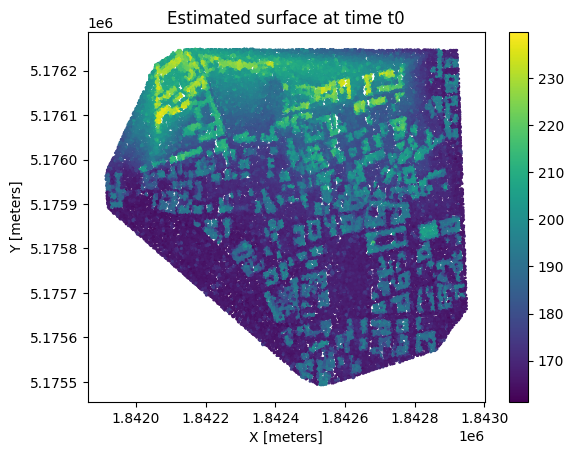

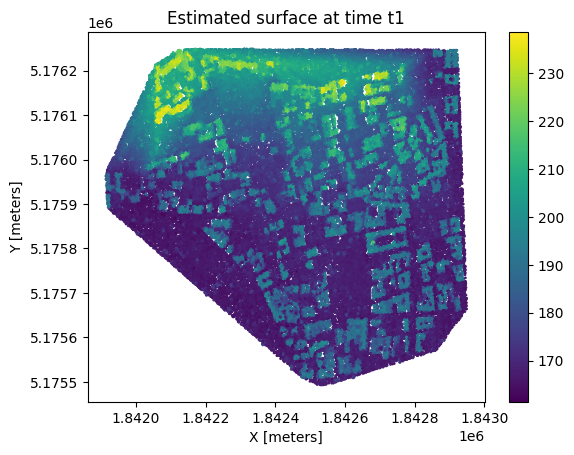

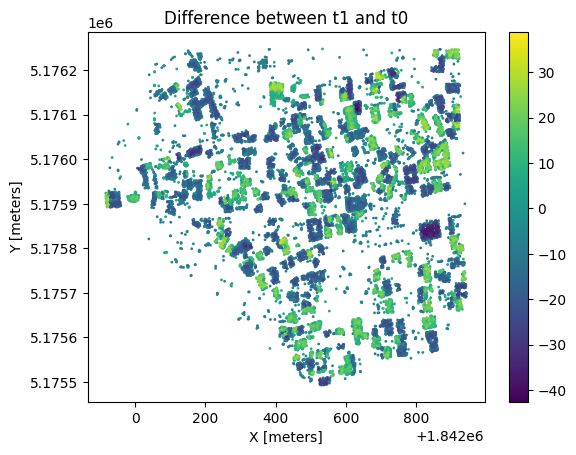

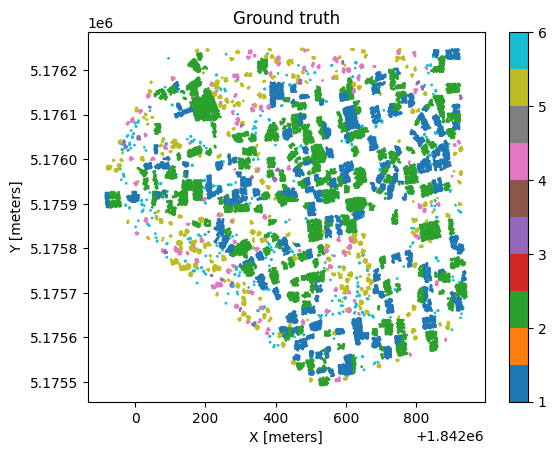

In [10]:
# Data visualization in x,y plane
# z encoded as color
ds = 4 # hard downsampling, just to make everything a bit faster
plt.scatter(x[::ds], y[::ds], c=f_z0[::ds], s=1)
plt.title('Estimated surface at time t0')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()

plt.scatter(x[::ds], y[::ds], c=f_z1[::ds], s=1)
plt.title('Estimated surface at time t1')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()

diff[np.abs(diff) < thresh] = np.nan
plt.scatter(x[::ds], y[::ds], c=diff[::ds], s=1)
plt.title('Difference between t1 and t0')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()

gt[gt == 0] = np.nan
plt.scatter(x[::ds], y[::ds], c=gt[::ds], cmap='tab10', s=1)
plt.title('Ground truth')
plt.ylabel('Y [meters]')
plt.xlabel('X [meters]')
plt.colorbar()
plt.show()